In [13]:
##GENERAL
import math 
import numpy as np
import pandas as pd
import warnings
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
import copy as co
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
%matplotlib inline
#!pip install termcolor 
from termcolor import colored


##MODULES
import mySQL_PBTK as db_query
import distribution_fitting as dfit

## Get all data from database and store in local tables

In [2]:
sp_table = db_query.sp_table()
oxc_table = db_query.oxygen_con_table()
q_table = db_query.cardiac_output_table()
tv_table = db_query.tissue_volumes_table()
lipid_table = db_query.lipid_content_table()
bf_table = db_query.blood_flow_table()

In [3]:
#print(sp_table.head())
#print(oxc_table.head())
#print(q_table.head())
#print(tv_table.head())
#print(lipid_table.head())
#print(bf_table.head())

### Scaling to normalized values for Cardiac Output and Oxygen Consumption to derive the normalized parameter distribution

In [4]:
def oxc_scaling():
    oxc = db_query.oxygen_con_table()
        
    #weight is in g, value is in mg O2/kg/h
    oxc_df = []
    weight_kg = []
    value_mg_h =[]
    VO2_w = []
    VO2_w_t = []
    
    for i in range(len(oxc.weight)):
        weight_kg.append((oxc.weight.astype(float)[i]/1000)) #to transform weight in kg
       
    for i in range(len(oxc.value)):
        value_mg_h.append(oxc.value.astype(float)[i]*weight_kg[i]) #value to actual weight mg/h
    
    for i in range(len(oxc.value)):
        VO2_w.append(oxc.value.astype(float)[i]/(math.pow(weight_kg[i], 0.8))) #scaled value 1kg fish mg/kg/h #scaling factor overall distribution is 0.8
    
    for i in range(len(VO2_w)):
        VO2_w_t.append(VO2_w[i]*math.pow(1.805,((15-oxc.temp.astype(float))[i]/10))) #1kg at 15C mg/h/kg #1.805 is q10 value from Cardiac Output #15 is temp that we want to scale for 
     
    oxc_df = [oxc.species, np.log10(VO2_w), oxc.temp.astype(float), np.log10(weight_kg), np.log10(value_mg_h), VO2_w_t]    
    
    # list of lists is converted to a dataframe
    df = dict(species= oxc_df[0], log_VO2_w = oxc_df[1],T= oxc_df[2], log_w = oxc_df[3], log_VO2= oxc_df[4], VO2_w_t = oxc_df[5])  ## first convert in a dict, to set the column names
    df = pd.DataFrame.from_dict(df, orient='columns', dtype=None)
    
    return df

In [5]:
def cardiac_output_scaling():
    q = db_query.cardiac_output_table()
        
    #weight is in g, value is in ml/min/kg
    q_df = []
    weight_kg = []
    value_L_h_kg = [] 
    value_L_h =[]
    Q_w_t = []
    
    for i in range(len(q.weight)):
        weight_kg.append((q.weight.astype(float)[i]/1000)) #to transform weight in kg
    
    for i in range(len(q.value)):
        value_L_h_kg.append((q.value.astype(float)[i]/1000)*60) #to transform value in L/h/kg
        
    for i in range(len(value_L_h_kg)):
        value_L_h.append(value_L_h_kg[i]*weight_kg[i]) #value to actual weight L/h
    
    for i in range(len(value_L_h_kg)):
        Q_w_t.append(value_L_h_kg[i]*math.pow(1.805,((15-q.temp.astype(float))[i]/10))) #1kg at 15C L/h/kg #1.805 is q10 value #15 is temp that we want to scale for 
    
    
    
    q_df = [q.species, q.temp.astype(float), np.log10(weight_kg), np.log10(value_L_h), Q_w_t]    
    
    #To make the analysis of the selected easier, the list of lists is converted to a dataframe
    df = dict(species= q_df[0], T = q_df[1], log_w = q_df[2], log_Q_L_h = q_df[3], Q_w_t = q_df[4] )  ## first convert in a dict, to set the column names
    df = pd.DataFrame.from_dict(df, orient='columns', dtype=None)
    
    return df

### Fitting the data to a propper distribtion so we can give this information to the random number generator.

Oxygen Consumption

low: 0.7685991995953059
high: 6.333428326607994
count: 1017


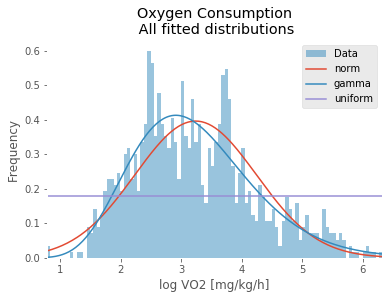

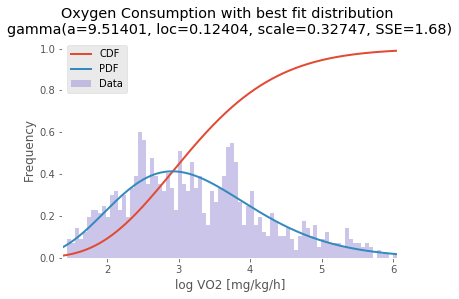

In [9]:
df= oxc_scaling()

# Load data from datasets and set axis titles
dataset = "Oxygen Consumption"
unit = "log VO2 [mg/kg/h]"
data= np.log10(df["VO2_w_t"])

bins=100

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

Cardiac Output

low: 0.44141546161971834
high: 3.369254336051081
count: 343


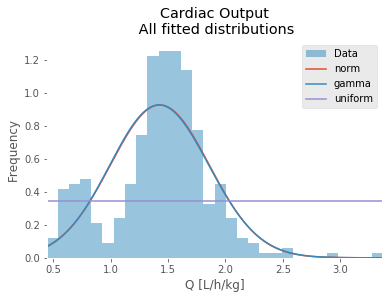

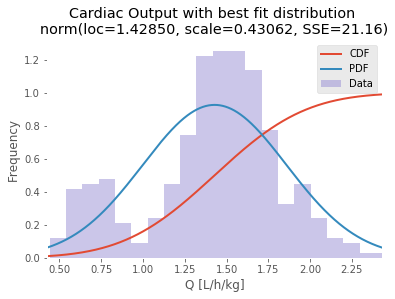

In [10]:
df = cardiac_output_scaling()

# Load data from datasets and set axis titles
dataset = "Cardiac Output"
unit = "Q [L/h/kg]"
data= df["Q_w_t"]
bins=30

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

# Tissue Volumes

Liver

low: 0.0059
high: 0.086
count: 370


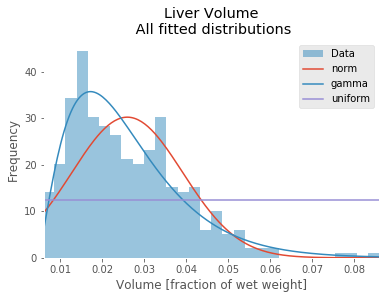

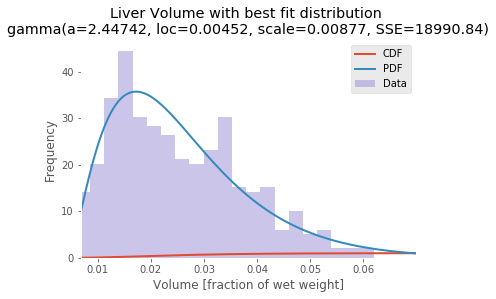

In [11]:
# Load data from datasets and set axis titles
dataset = "Liver Volume"
unit = 'Volume [fraction of wet weight]'
liver = tv_table[tv_table.tissue == 'liver']
data = liver.value/100 #due to fractions used in model    
bins = 30

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

Gonads

low: 0.0005899999999999999
high: 0.4127
n: 471


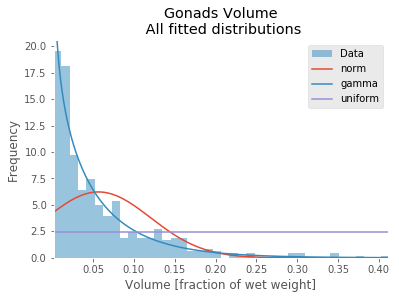

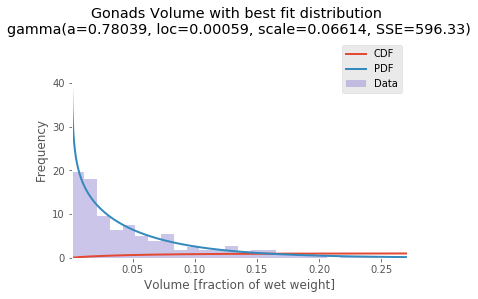

In [38]:
# Load data from datasets and set axis titles
dataset = "Gonads Volume"
unit = 'Volume [fraction of wet weight]'
gonads = tv_table[tv_table.tissue == 'gonads']
data= gonads.value/100 #due to fractions used in model  
bins = 40

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

low: 0.00217
high: 0.01311
n: 53


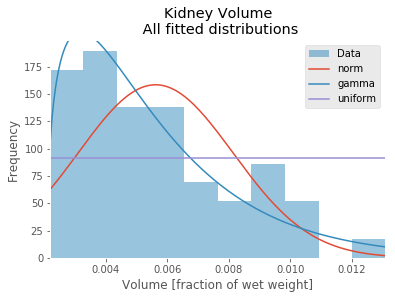

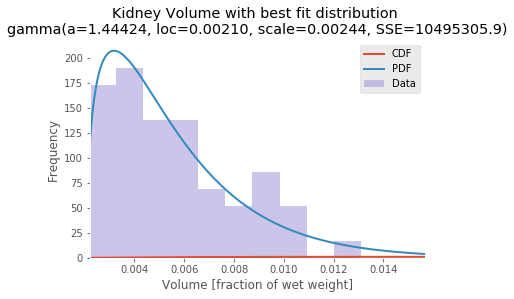

In [34]:
# Load data from datasets and set axis titles
dataset = "Kidney Volume"
unit = 'Volume [fraction of wet weight]'
kidney = tv_table[tv_table.tissue == 'kidney']
data = kidney.value/100 #due to fractions used in model  
bins = 10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

In [33]:
# Load data from datasets and set axis titles
#dataset = "PPT Volume"
#unit = 'Volume [fraction of wet weight]'
ppt = tv_table[tv_table.tissue == 'ppt']
data= ppt.value/100 #due to fractions used in model  
#bins = 10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

#dfit.distribution_plot(dataset, unit, data, bins)

low: 0.741
high: 0.9395319999999999
count: 51


low: 0.014790000000000001
high: 0.11
count: 55


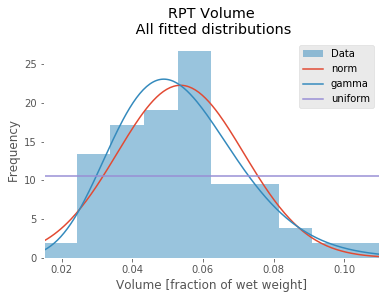

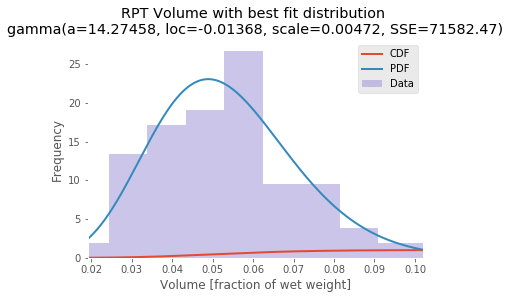

In [15]:
# Load data from datasets and set axis titles
dataset = "RPT Volume"
unit = 'Volume [fraction of wet weight]'
rpt = tv_table[tv_table.tissue == 'rpt']
data= rpt.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

In [32]:
# Load data from datasets and set axis titles
#dataset = "Fat Volume"
#unit = 'Volume [fraction of wet weight]'
fat = tv_table[tv_table.tissue == 'fat']
data= fat.value/100 #due to fractions used in model  
#bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

#dfit.distribution_plot(dataset, unit, data,bins)

low: 0.00057
high: 0.1
count: 16


# Lipid Contents

Liver

low: 0.0175
high: 0.5379999999999999
count: 53


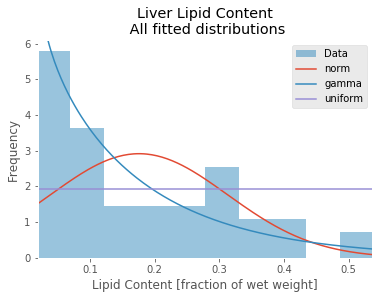

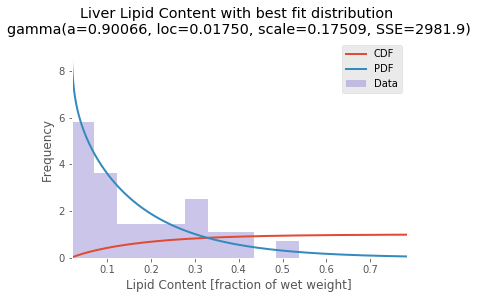

In [17]:
# Load data from datasets and set axis titles
dataset = "Liver Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
liver = lipid_table[lipid_table.tissue == 'liver']
data= liver.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

low: 0.0088
high: 0.1184
count: 15


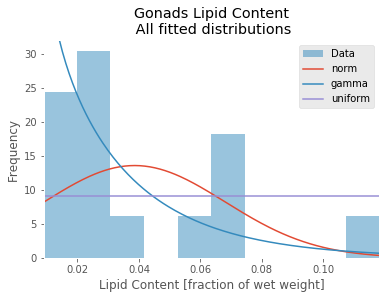

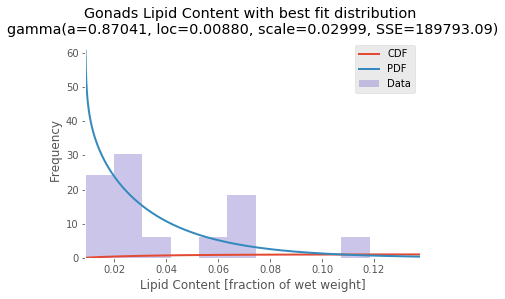

In [18]:
# Load data from datasets and set axis titles
dataset = "Gonads Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
gonads = lipid_table[lipid_table.tissue == 'gonads']
data= gonads.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

low: 0.00299
high: 0.2487
n: 29


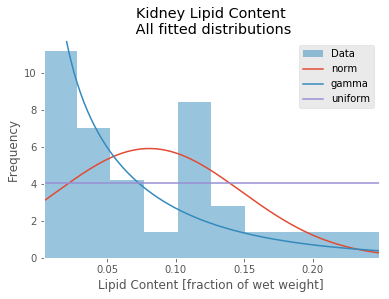

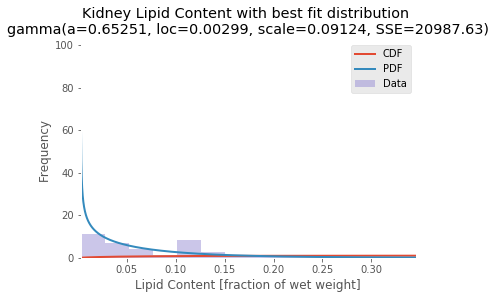

In [39]:
# Load data from datasets and set axis titles
dataset = "Kidney Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
kidney = lipid_table[lipid_table.tissue == 'kidney']
data= kidney.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

In [ ]:
# PPT forced to be gamma

low: 0.0028000000000000004
high: 0.2416
n: 152


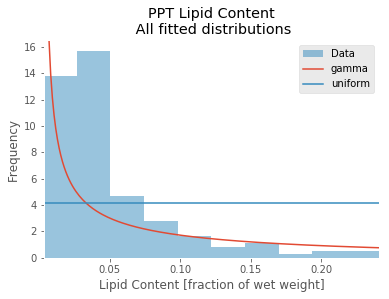

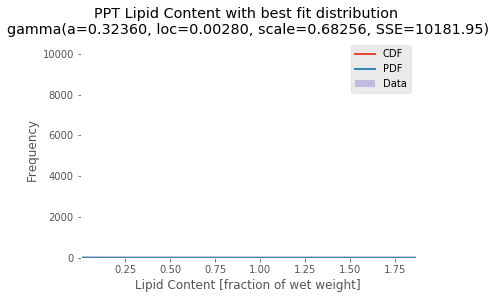

In [3]:
# Load data from datasets and set axis titles
dataset = "PPT Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
ppt = lipid_table[lipid_table.tissue == 'ppt']
data= ppt.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

In [4]:
# Load data from datasets and set axis titles
#dataset = "RPT Lipid Content"
#unit = 'Lipid Content [fraction of wet weight]'
rpt = lipid_table[lipid_table.tissue == 'rpt']
data= rpt.value/100 #due to fractions used in model  
#bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

#dfit.distribution_plot(dataset, unit, data,bins)

low: 0.03214
high: 0.33299999999999996
n: 29


low: 0.6551
high: 1.0
count: 20


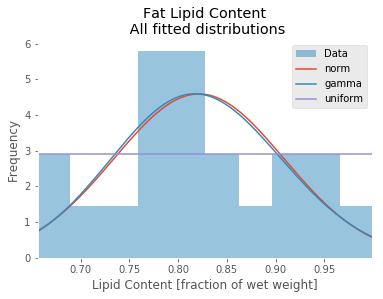

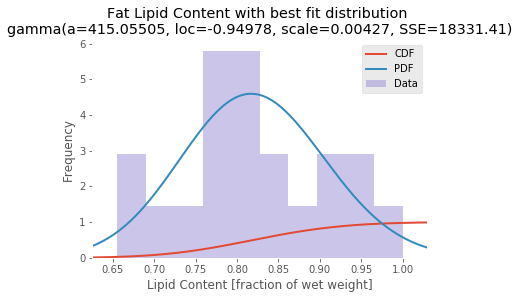

In [22]:
# Load data from datasets and set axis titles
dataset = "Fat Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
fat = lipid_table[lipid_table.tissue == 'fat']
data= fat.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

low: 0.0059
high: 0.019
count: 18


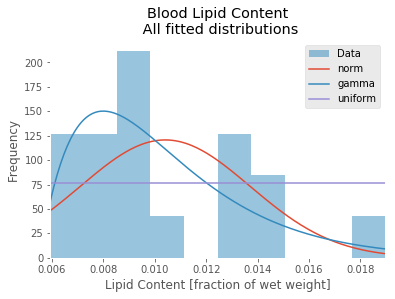

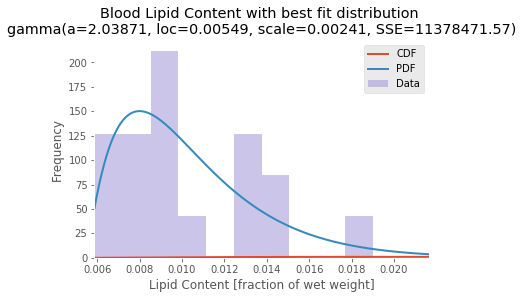

In [23]:
# Load data from datasets and set axis titles
dataset = "Blood Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
blood = lipid_table[lipid_table.tissue == 'blood']
data= blood.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

low: 0.0116
high: 0.248
count: 50


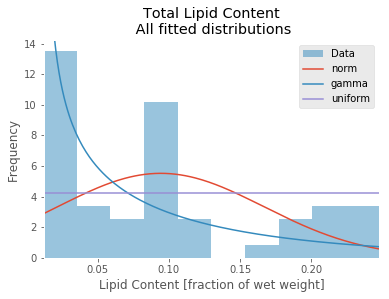

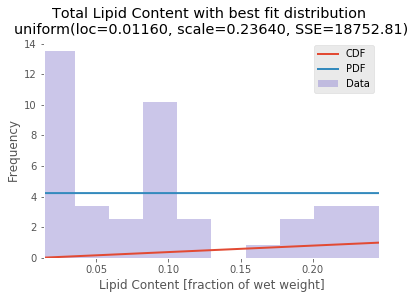

In [24]:
# Load data from datasets and set axis titles
dataset = "Total Lipid Content"
unit = 'Lipid Content [fraction of wet weight]'
total = lipid_table[lipid_table.tissue == 'total']
data= total.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

# Blood flows

Liver

low: 5.37753e-05
high: 0.17170100000000002
count: 17


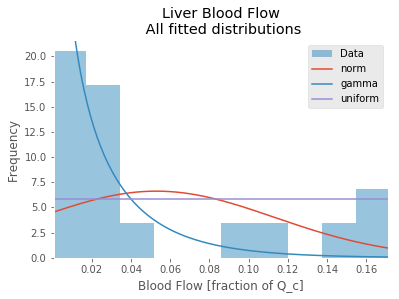

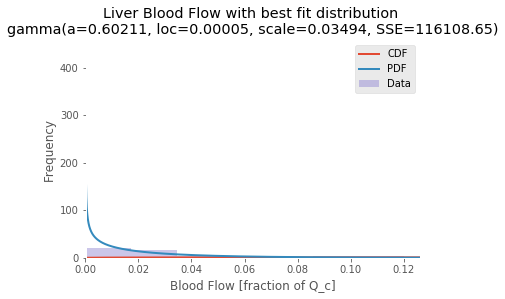

In [25]:
# Load data from datasets and set axis titles
dataset = "Liver Blood Flow"
unit = 'Blood Flow [fraction of Q_c]'
liver = bf_table[bf_table.tissue == 'liver']
data = liver.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

In [36]:
# Load data from datasets and set axis titles
#dataset = "Gonads Blood Flow"
#unit = 'Volume [fraction of Q_c]'
gonads = bf_table[bf_table.tissue == 'gonads']
data= gonads.value/100 #due to fractions used in model  
#bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

#dfit.distribution_plot(dataset, unit, data,bins)

low: 2.60282e-05
high: 0.011200000000000002
n: 5


low: 0.00157154
high: 0.11
count: 16


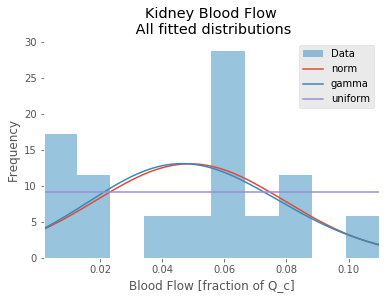

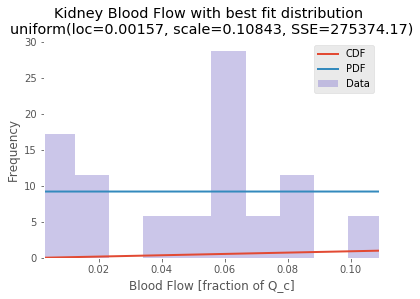

In [27]:
# Load data from datasets and set axis titles
dataset = "Kidney Blood Flow"
unit = 'Blood Flow [fraction of Q_c]'
kidney = bf_table[bf_table.tissue == 'kidney']
data= kidney.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

low: 0.44
high: 0.993846
count: 14


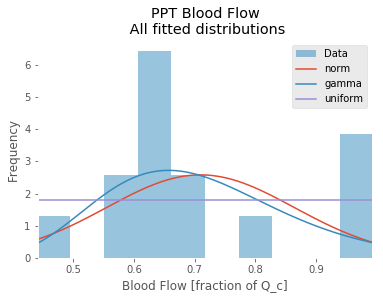

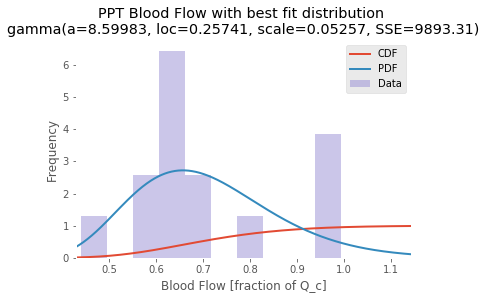

In [28]:
# Load data from datasets and set axis titles
dataset = "PPT Blood Flow"
unit = 'Blood Flow [fraction of Q_c]'
ppt = bf_table[bf_table.tissue == 'ppt']
data= ppt.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data,bins)

low: 0.00425561
high: 0.526
count: 14


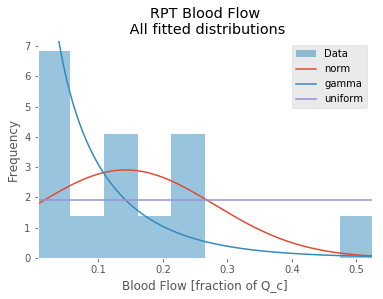

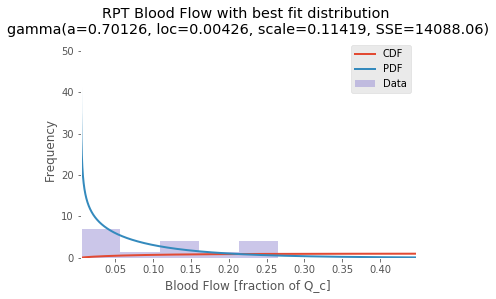

In [29]:
# Load data from datasets and set axis titles
dataset = "RPT Blood Flow"
unit = 'Blood Flow [fraction of Q_c]'
rpt = bf_table[bf_table.tissue == 'rpt']
data= rpt.value/100 #due to fractions used in model  
bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

dfit.distribution_plot(dataset, unit, data, bins)

In [37]:
# Load data from datasets and set axis titles
#dataset = "Fat Blood Flow"
#unit = 'Blood Flow [fraction of Q_c]'
fat = bf_table[bf_table.tissue == 'fat']
data= fat.value/100 #due to fractions used in model  
#bins=10

print('low: '+str(min(data)))
print('high: '+str(max(data)))
print('n: '+str(data.count()))

#dfit.distribution_plot(dataset, unit, data,bins)

low: 0.0001
high: 0.11199999999999999
n: 6
